# Cardiovascular Disease MLOps Final Project
## Group 4: Prema Mallikarjunan and Outhai Xayavongsa

### Import and Install Libraries

In [ ]:
# Install dependencies if needed
!pip install pyathena sqlalchemy pandas matplotlib seaborn fsspec s3fs --quiet

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy.engine import create_engine
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import boto3
from io import StringIO
from io import BytesIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import os

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Load Data from Athena

In [4]:
# Connect to Athena using SQLAlchemy
# Change Sagemaker number and folder
region = "us-east-1"
# s3_path = "s3://aws-athena-query-results-381492296191-us-east-1/staging/" # Prema's path
s3_path = "s3://sagemaker-us-east-1-531690656306/staging/" # Thai's path
athena_engine = create_engine(
    f"awsathena+rest://@athena.{region}.amazonaws.com/finalgroup4?s3_staging_dir={s3_path}"
)

In [5]:
# Load data from Athena table
# Define your SQL query

file_path = "cardio_train.csv"
df = pd.read_csv(file_path, sep=';')

print(df.head())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  


### Data Understanding

In [6]:
# Data Understanding
df_overview = df.describe().transpose()
df_info = pd.DataFrame({
    "Column": df.columns,
    "Data Type": df.dtypes,
    "Missing Values": df.isnull().sum(),
    "Unique Values": df.nunique()
})
display(df_overview)
display(df_info)

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


,Column,Data Type,Missing Values,Unique Values
id,id,int64,0,70000
age,age,int64,0,8076
gender,gender,int64,0,2
height,height,int64,0,109
weight,weight,float64,0,287
ap_hi,ap_hi,int64,0,153
ap_lo,ap_lo,int64,0,157
cholesterol,cholesterol,int64,0,3
gluc,gluc,int64,0,3
smoke,smoke,int64,0,2


### Data Cleaning

This code cleans and formats the cardiovascular dataset by first converting age from days to years and removing physiologically implausible values based on clinical thresholds for blood pressure, height, and weight. It drops the non-informative id column and renames ap_hi and ap_lo to systolic_bp and diastolic_bp for clarity. To enhance interpretability, it converts height from centimeters to feet and weight from kilograms to pounds, rounding both to two decimal places. Finally, it displays a refined set of columns focused on the most meaningful features, excluding raw height and weight while highlighting the transformed units.

In [7]:
# Cleaning the data
df_cleaned = df.copy()

# Convert age from days to years
df_cleaned['age'] = df_cleaned['age'] // 365

# Remove physiological outliers based on domain knowledge
df_cleaned = df_cleaned[
    (df_cleaned['ap_hi'] >= 90) & (df_cleaned['ap_hi'] <= 200) &
    (df_cleaned['ap_lo'] >= 60) & (df_cleaned['ap_lo'] <= 120) &
    (df_cleaned['height'] >= 100) & (df_cleaned['height'] <= 220) &
    (df_cleaned['weight'] >= 30) & (df_cleaned['weight'] <= 200)
]

# Drop non-predictive identifier
df_cleaned.drop(columns=['id'], inplace=True)

# Rename blood pressure columns for clarity
df_cleaned.rename(columns={
    'ap_hi': 'systolic_bp',
    'ap_lo': 'diastolic_bp'
}, inplace=True)

# Convert and round height (cm → ft) and weight (kg → lbs)
df_cleaned['height_ft'] = (df_cleaned['height'] * 0.0328084).round(2)
df_cleaned['weight_lbs'] = (df_cleaned['weight'] * 2.20462).round(2)

# Drop original height and weight
df_cleaned = df_cleaned.drop(columns=['height', 'weight'])

# Reorder columns with height_ft and weight_lbs placed after gender
ordered_columns = ['age', 'gender', 'height_ft', 'weight_lbs', 'systolic_bp', 'diastolic_bp',
                   'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Apply the new column order
df_cleaned = df_cleaned[ordered_columns]

# Confirm the reordering
df_cleaned.head()

,age,gender,height_ft,weight_lbs,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,5.51,136.69,110,80,1,1,0,0,1,0
1,55,1,5.12,187.39,140,90,3,1,0,0,1,1
2,51,1,5.41,141.10,130,70,3,1,0,0,0,1
3,48,2,5.54,180.78,150,100,1,1,0,0,1,1
4,47,1,5.12,123.46,100,60,1,1,0,0,0,0


In [8]:
# File Saved after Cleaning
df_cleaned.to_csv("cardio_cleaned.csv", index=False)

In [9]:
# Upload to your S3 bucket
!aws s3 cp cardio_cleaned.csv s3://sagemaker-us-east-1-531690656306/cardio_data/

upload: ./cardio_cleaned.csv to s3://sagemaker-us-east-1-531690656306/cardio_data/cardio_cleaned.csv


### Exploratory Data Analysis

In [10]:
# Initialize the S3 client using the cleaned dataset
s3 = boto3.client('s3')
bucket_name = 'sagemaker-us-east-1-531690656306'
file_key = 'cardio_data/cardio_cleaned.csv'

# Load the cardio_cleaned.csv file from S3
response = s3.get_object(Bucket=bucket_name, Key=file_key)
df_cleaned = pd.read_csv(BytesIO(response['Body'].read()))

# Print entire list of columns in the cleaned dataset
print(df_cleaned.columns.tolist())

['age', 'gender', 'height_ft', 'weight_lbs', 'systolic_bp', 'diastolic_bp', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


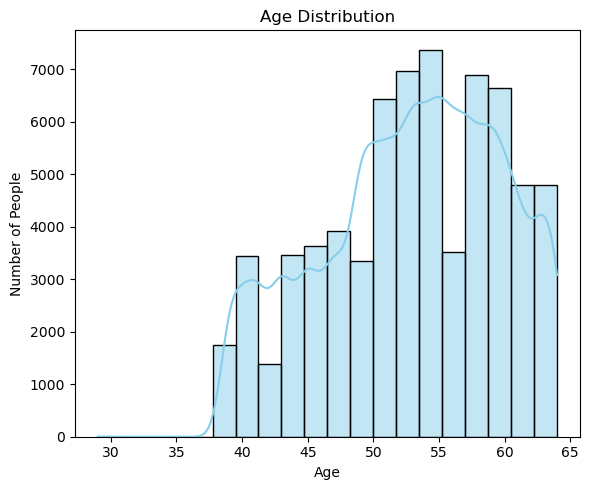

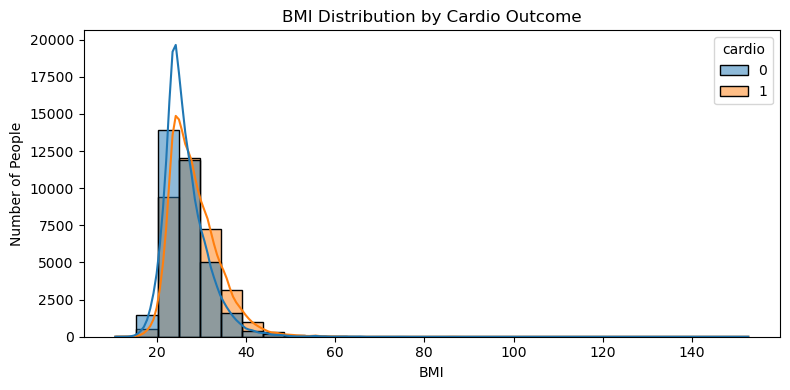

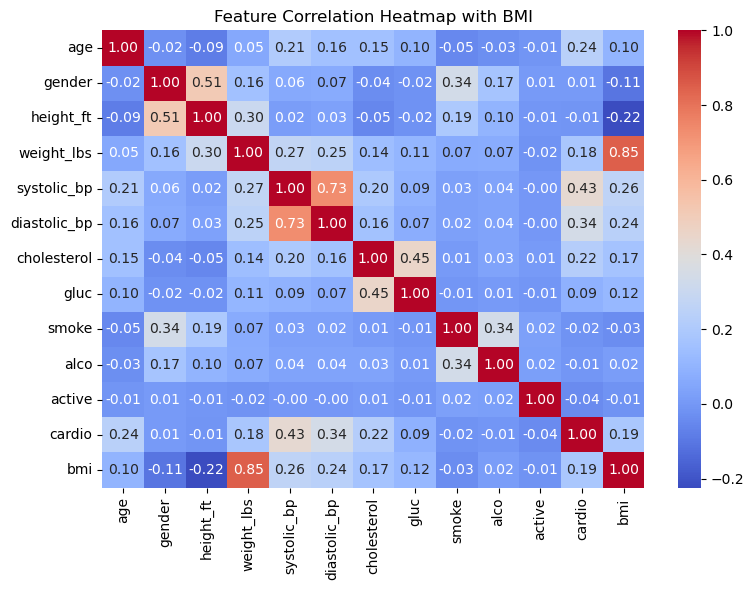

In [11]:
# Calculate BMI from weight (lbs) and height (ft)
df_cleaned['bmi'] = (df_cleaned['weight_lbs'] / (df_cleaned['height_ft'] ** 2)) * 4.88 

# Age Distribution
plt.figure(figsize=(6, 5))
sns.histplot(data=df_cleaned, x='age', kde=True, bins=20, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

# BMI Distribution by Cardio Outcome
plt.figure(figsize=(8, 4))
sns.histplot(data=df_cleaned, x='bmi', hue='cardio', kde=True, bins=30)
plt.title('BMI Distribution by Cardio Outcome')
plt.xlabel('BMI')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

# Correlation Heatmap (numeric columns only)
numeric_cols = df_cleaned.select_dtypes(include='number')
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_cols.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap with BMI')
plt.tight_layout()
plt.show()

#### BMI Distribution by Cardio Outcome
The histogram shows a right-skewed BMI distribution for both groups, with individuals diagnosed with cardiovascular disease (cardio = 1) displaying a broader spread and slightly higher BMI values. This rightward shift implies a modest but noticeable association between elevated BMI and the presence of cardiovascular disease. The trend aligns with medical evidence that increased body mass raises cardiovascular risk, even when the statistical strength appears moderate.

#### Feature Store Correlation Matrix Heatmap
The Pearson heatmap highlights key relationships among features. BMI correlates strongly with weight_lbs (0.85), which is expected given BMI's dependency on weight and height.
* BMI (0.19)
* Systolic blood pressure (0.43)
* Age (0.24)
* Cholesterol (0.22)
  
These values suggest that no single factor dominates risk, but a combination of elevated vital signs, aging, and body composition contributes meaningfully to CVD prediction. Low inter-feature correlations also indicate minimal multicollinearity, supporting the use of these variables in modeling.

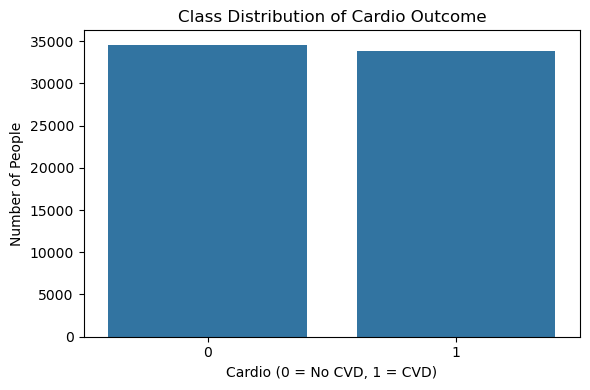

Class Counts:
 cardio
0    34547
1    33838
Name: count, dtype: int64

Class Distribution (%):
 cardio
0    50.52
1    49.48
Name: proportion, dtype: float64


In [12]:
# Check for Imbalance
# Check class distribution in the cleaned dataset
plt.figure(figsize=(6, 4))
sns.countplot(x='cardio', data=df_cleaned)
plt.title('Class Distribution of Cardio Outcome')
plt.xlabel('Cardio (0 = No CVD, 1 = CVD)')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

# Print raw counts
class_counts = df_cleaned['cardio'].value_counts()
print("Class Counts:\n", class_counts)

# Print percentage distribution
class_percent = df_cleaned['cardio'].value_counts(normalize=True) * 100
print("\nClass Distribution (%):\n", class_percent.round(2))


The dataset is well balanced, with 50.52% of instances labeled as non-cardiovascular disease (0) and 49.48% as cardiovascular disease (1).<br> 
This near-even class distribution reduces the risk of bias during model training.

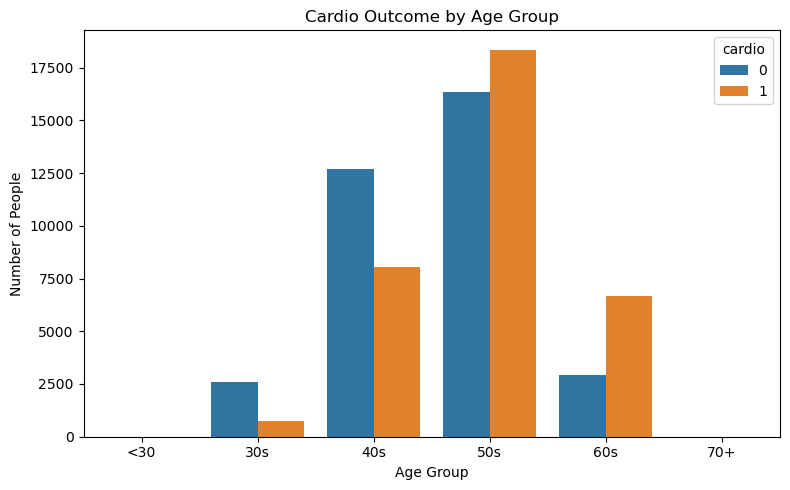

In [13]:
# Age Group Distribution by Cardio Outcome
df_cleaned['age_group'] = pd.cut(df_cleaned['age'], bins=[0, 30, 40, 50, 60, 70, 100],
                                 labels=['<30', '30s', '40s', '50s', '60s', '70+'])

# Plot age group distribution by cardio outcome
plt.figure(figsize=(8, 5))
sns.countplot(data=df_cleaned, x='age_group', hue='cardio')
plt.title('Cardio Outcome by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of People')
plt.tight_layout()
plt.show()

The chart shows the distribution of cardiovascular disease (CVD) outcomes across different age groups. Most cases, both positive and negative, occur in the 40s to 60s age range. The highest number of CVD cases (cardio = 1) appears in the <b>50s group</b>, suggesting increased cardiovascular risk in middle age. Younger age groups have far fewer cases, indicating age is a significant risk factor for developing heart conditions.

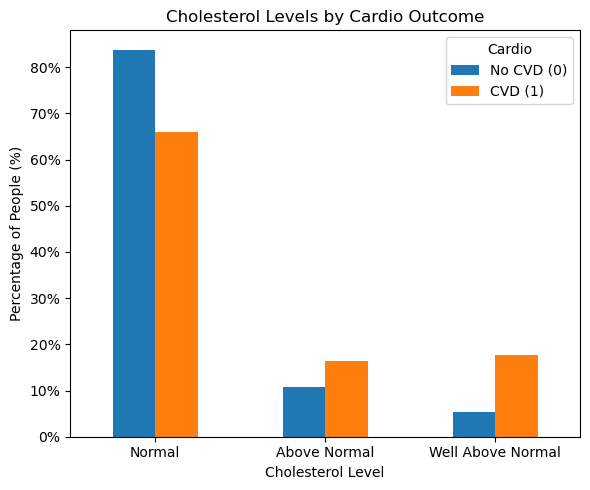

In [14]:
# Map cholesterol levels to readable labels
chol_map = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'}
df_cleaned['cholesterol_label'] = df_cleaned['cholesterol'].map(chol_map)

# Define category order
chol_order = ['Normal', 'Above Normal', 'Well Above Normal']

# Calculate percentage distribution by cardio outcome
chol_summary = df_cleaned.groupby(['cardio', 'cholesterol_label']).size().unstack().fillna(0)
chol_summary = chol_summary[chol_order]  # Ensure correct order
chol_percent = chol_summary.div(chol_summary.sum(axis=1), axis=0) * 100

# Plot
chol_percent.T.plot(kind='bar', figsize=(6, 5))
plt.title('Cholesterol Levels by Cardio Outcome')
plt.ylabel('Percentage of People (%)')
plt.xlabel('Cholesterol Level')
plt.xticks(rotation=0)
plt.legend(title='Cardio', labels=['No CVD (0)', 'CVD (1)'])

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.tight_layout()
plt.show()

The bar chart shows the distribution of cholesterol levels by cardiovascular disease (CVD) outcome. Individuals without CVD (cardio = 0) overwhelmingly fall into the Normal cholesterol category (over 80%), while a smaller share have Above Normal or Well Above Normal levels. In contrast, individuals with CVD (cardio = 1) have a noticeably lower percentage in the Normal range (about 66%) and higher proportions in the elevated cholesterol categories. This suggests a clear association between higher cholesterol levels and cardiovascular disease, reinforcing cholesterol as a contributing factor to heart conditions.

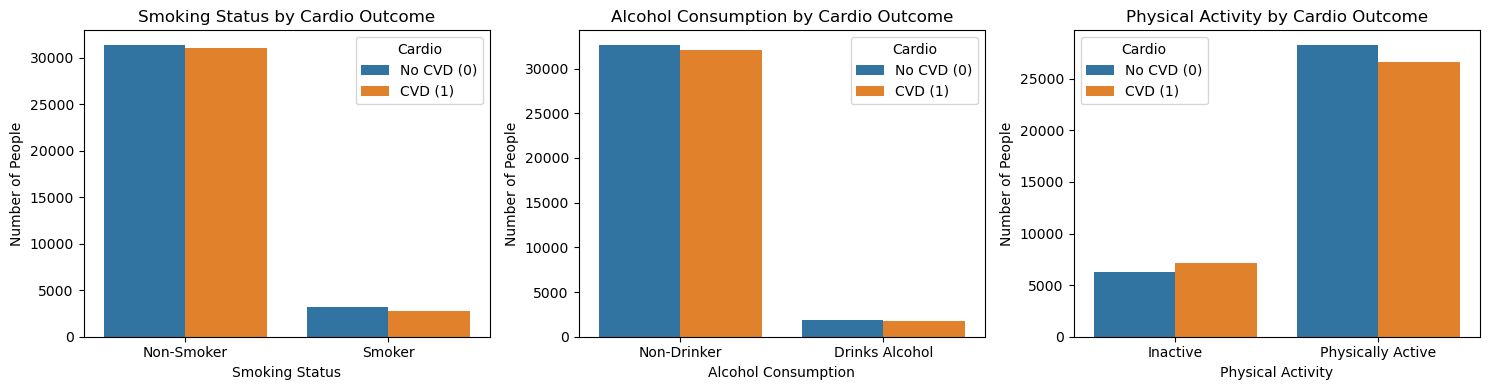

In [15]:
# Lifestyle Features Breakdown (smoke, alco, active)
# Define readable x-axis labels
feature_labels = {
    'smoke': ['Non-Smoker', 'Smoker'],
    'alco': ['Non-Drinker', 'Drinks Alcohol'],
    'active': ['Inactive', 'Physically Active']
}

# Define proper titles for each feature
feature_titles = {
    'smoke': 'Smoking Status',
    'alco': 'Alcohol Consumption',
    'active': 'Physical Activity'
}

# Set up subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
features = ['smoke', 'alco', 'active']

# Loop through features and plot each
for i, col in enumerate(features):
    ax = axes[i]
    sns.countplot(x=col, hue='cardio', data=df_cleaned, ax=ax)
    ax.set_title(f'{feature_titles[col]} by Cardio Outcome')
    ax.set_xlabel(feature_titles[col])
    ax.set_ylabel('Number of People')
    ax.set_xticklabels(feature_labels[col])
    ax.legend(title='Cardio', labels=['No CVD (0)', 'CVD (1)'])

plt.tight_layout()
plt.show()


These three visualizations reveal lifestyle patterns about cardiovascular disease (CVD):

* <i>Smoking:</i> Both CVD and non-CVD groups show similar smoking behavior, with the vast majority being non-smokers. Smoking appears only slightly more prevalent among non-CVD individuals.
* <i>Alcohol Consumption:</i> Most participants are non-drinkers across both groups. The proportion of alcohol consumers is nearly identical, suggesting limited distinction in CVD risk based on alcohol use alone.
* <i>Physical Activity:</i> Physical activity shows more contrast. A noticeably larger portion of the non-CVD group is physically active, while inactivity is slightly higher among those with CVD, reinforcing the known protective effect of exercise.

Together, these patterns indicate that while smoking and alcohol have minimal visual separation, <b>physical activity stands out as a modest but meaningful lifestyle indicator for CVD risk.</b>

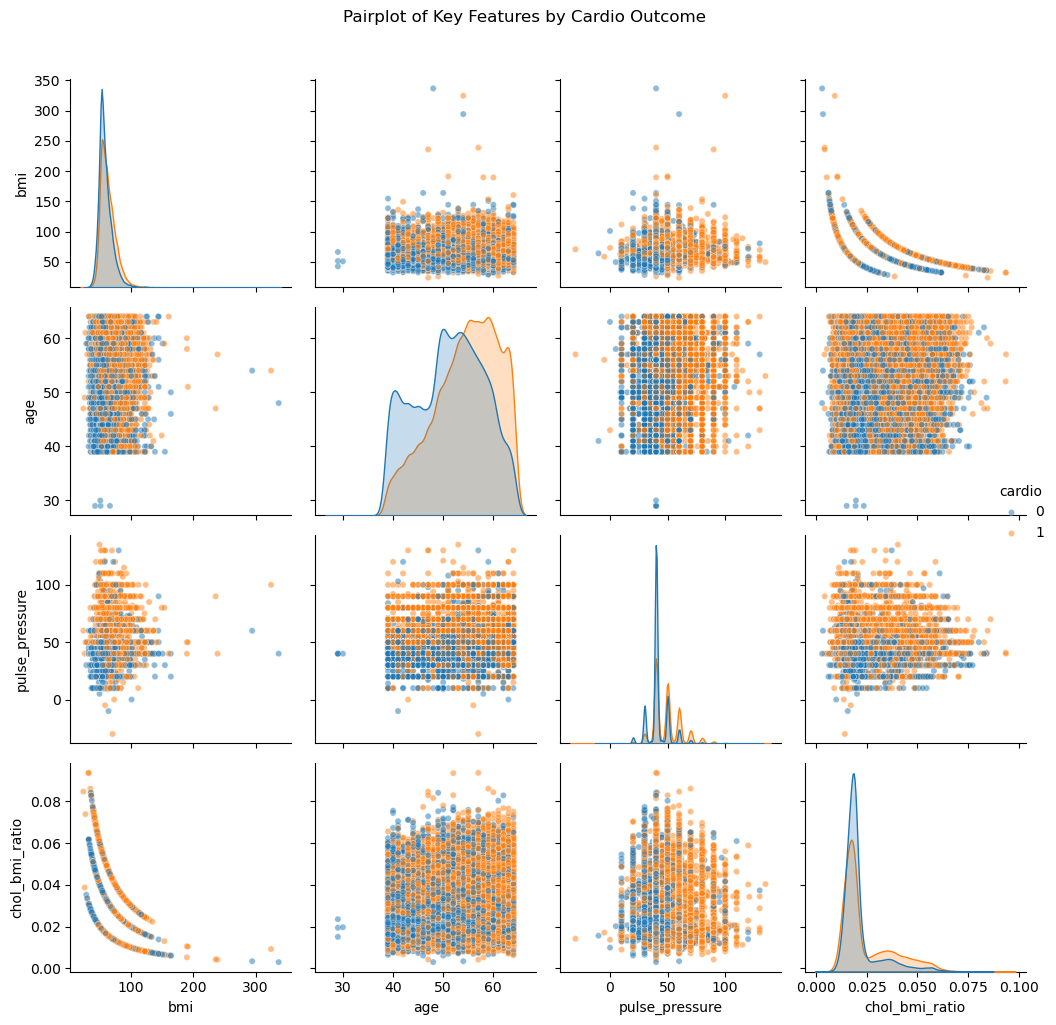

In [16]:
# Calculate features for visualization
df_cleaned['bmi'] = df_cleaned['weight_lbs'] / ((df_cleaned['height_ft'] / 3.281) ** 2)
df_cleaned['pulse_pressure'] = df_cleaned['systolic_bp'] - df_cleaned['diastolic_bp']
df_cleaned['chol_bmi_ratio'] = df_cleaned['cholesterol'] / (df_cleaned['bmi'] + 1e-5)

# Select features for the pairplot
pairplot_features = ['bmi', 'age', 'pulse_pressure', 'chol_bmi_ratio', 'cardio']

# Create the pairplot
sns.pairplot(df_cleaned[pairplot_features], hue='cardio', plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle('Pairplot of Key Features by Cardio Outcome', y=1.02)
plt.tight_layout()
plt.show()

In this pairplot of key features (BMI, age, pulse pressure, and cholesterol-to-BMI ratio) split by cardio outcome, a standout insight is the<b> distinct inverse nonlinear curve between BMI and chol_bmi_ratio </b>as BMI increases, the ratio compresses sharply. Despite lower ratios, cardio-positive cases still appear frequently, suggesting underlying metabolic risks not fully captured by BMI or cholesterol alone. Pulse pressure distributions also shift subtly higher in the CVD group, reinforcing its predictive value. Overall, this plot highlights how engineered features can reveal nuanced risk patterns that raw data often obscures.

### Feature Engineering & Augmentation
Categorical Binning and Interaction Terms

In [17]:
# Load the cleaned dataset 
df_engineered = df_cleaned.copy()

# Convert into US standard for easier readability
df_engineered['height_in'] = (df_engineered['height_ft'] * 12).round(2)  # Convert height from feet to inches
df_engineered['bmi'] = ((df_engineered['weight_lbs'] / (df_engineered['height_in'] ** 2)) * 703).round(2)  # BMI (U.S. standard)
df_engineered['pulse_pressure'] = (df_engineered['systolic_bp'] - df_engineered['diastolic_bp']).round(2)
df_engineered['age_years'] = df_engineered['age']

# Hypertension flag
df_engineered['is_hypertensive'] = (df_engineered['systolic_bp'] >= 140).astype(int)

# Blood pressure category
def bp_category(row):
    if row['systolic_bp'] < 120 and row['diastolic_bp'] < 80:
        return 'normal'
    elif 120 <= row['systolic_bp'] < 130 and row['diastolic_bp'] < 80:
        return 'elevated'
    elif 130 <= row['systolic_bp'] < 140 or 80 <= row['diastolic_bp'] < 90:
        return 'stage1'
    elif row['systolic_bp'] >= 140 or row['diastolic_bp'] >= 90:
        return 'stage2'
    else:
        return 'crisis'

# BMI category
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'normal'
    elif 25 <= bmi < 30:
        return 'overweight'
    else:
        return 'obese'

# Apply categorical binning
df_engineered['bp_category'] = df_engineered.apply(bp_category, axis=1)
df_engineered['bmi_category'] = df_engineered['bmi'].apply(bmi_category)
df_engineered['age_group'] = pd.cut(
    df_engineered['age_years'],
    bins=[0, 30, 40, 50, 60, 70, 100],
    labels=['<30', '30s', '40s', '50s', '60s', '70+'],
    right=False
)

# Interaction features
df_engineered['age_gluc_interaction'] = (df_engineered['age_years'] * df_engineered['gluc']).round(2)
df_engineered['chol_bmi_ratio'] = ((df_engineered['cholesterol'] / (df_engineered['bmi'] + 1e-5)) * 100).round(2)
df_engineered['lifestyle_score'] = (df_engineered['smoke'] + df_engineered['alco'] - df_engineered['active']).round(2)

# Display confirmation
df_engineered.head()

,age,gender,height_ft,weight_lbs,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,...,cholesterol_label,pulse_pressure,chol_bmi_ratio,height_in,age_years,is_hypertensive,bp_category,bmi_category,age_gluc_interaction,lifestyle_score
0,50,2,5.51,136.69,110,80,1,1,0,0,...,Normal,30,4.55,66.12,50,0,stage1,normal,50,-1
1,55,1,5.12,187.39,140,90,3,1,0,0,...,Well Above Normal,50,8.60,61.44,55,1,stage2,obese,55,-1
2,51,1,5.41,141.10,130,70,3,1,0,0,...,Well Above Normal,60,12.74,64.92,51,0,stage1,normal,51,0
3,48,2,5.54,180.78,150,100,1,1,0,0,...,Normal,50,3.48,66.48,48,1,stage2,overweight,48,-1
4,47,1,5.12,123.46,100,60,1,1,0,0,...,Normal,40,4.35,61.44,47,0,normal,normal,47,0


In [18]:
# Confirm columns added
df_engineered[['bp_category', 'bmi_category', 'age_group', 
               'age_gluc_interaction', 'chol_bmi_ratio', 'lifestyle_score']].head()

,bp_category,bmi_category,age_group,age_gluc_interaction,chol_bmi_ratio,lifestyle_score
0,stage1,normal,50s,50,4.55,-1
1,stage2,obese,50s,55,8.60,-1
2,stage1,normal,50s,51,12.74,0
3,stage2,overweight,40s,48,3.48,-1
4,normal,normal,40s,47,4.35,0


In [19]:
# Shape of New Features
print("Shape of df_engineered:", df_engineered.shape)

Shape of df_engineered: (68385, 24)


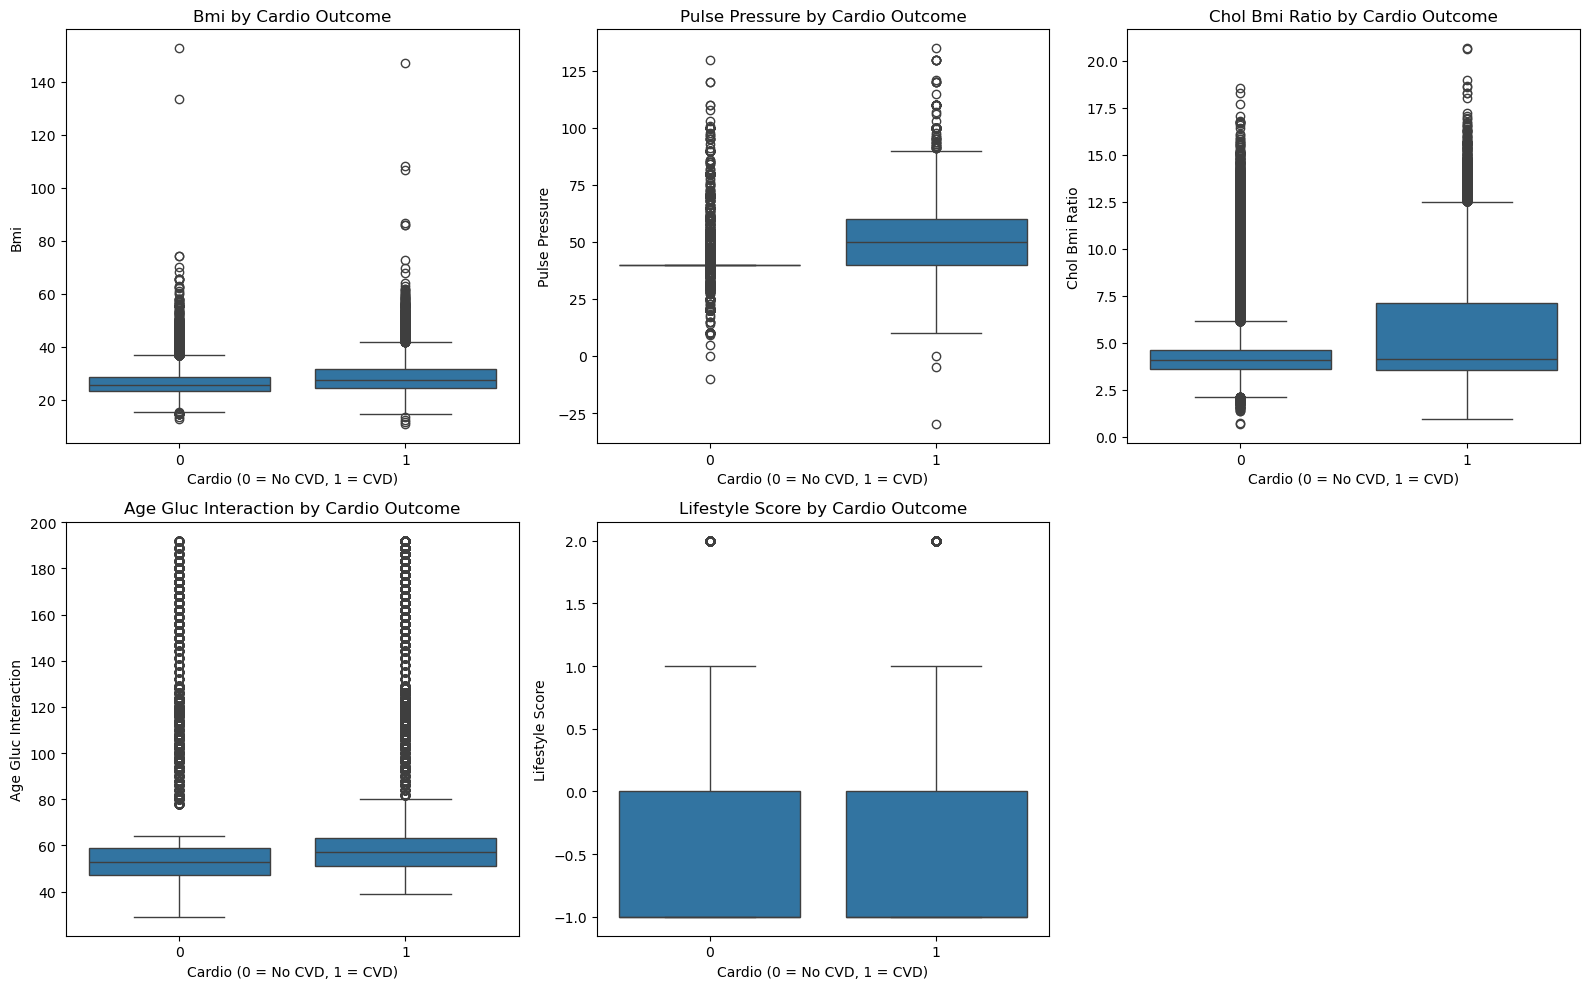

In [20]:
# Create box plots for each feature
features_to_plot = ['bmi', 'pulse_pressure', 'chol_bmi_ratio', 'age_gluc_interaction', 'lifestyle_score']
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='cardio', y=feature, data=df_engineered)
    plt.title(f'{feature.replace("_", " ").title()} by Cardio Outcome')
    plt.xlabel('Cardio (0 = No CVD, 1 = CVD)')
    plt.ylabel(feature.replace("_", " ").title())
plt.tight_layout()
plt.show()

This boxplot shows that individuals with cardiovascular disease (cardio = 1) have noticeably higher pulse pressure compared to those without. The distribution for cardio = 1 is broader, indicating greater variability and a higher median, while the cardio = 0 group is more concentrated. These patterns suggest that elevated pulse pressure may be a meaningful predictor of cardiovascular risk. However, the presence of extreme outliers in both groups warrants further inspection.

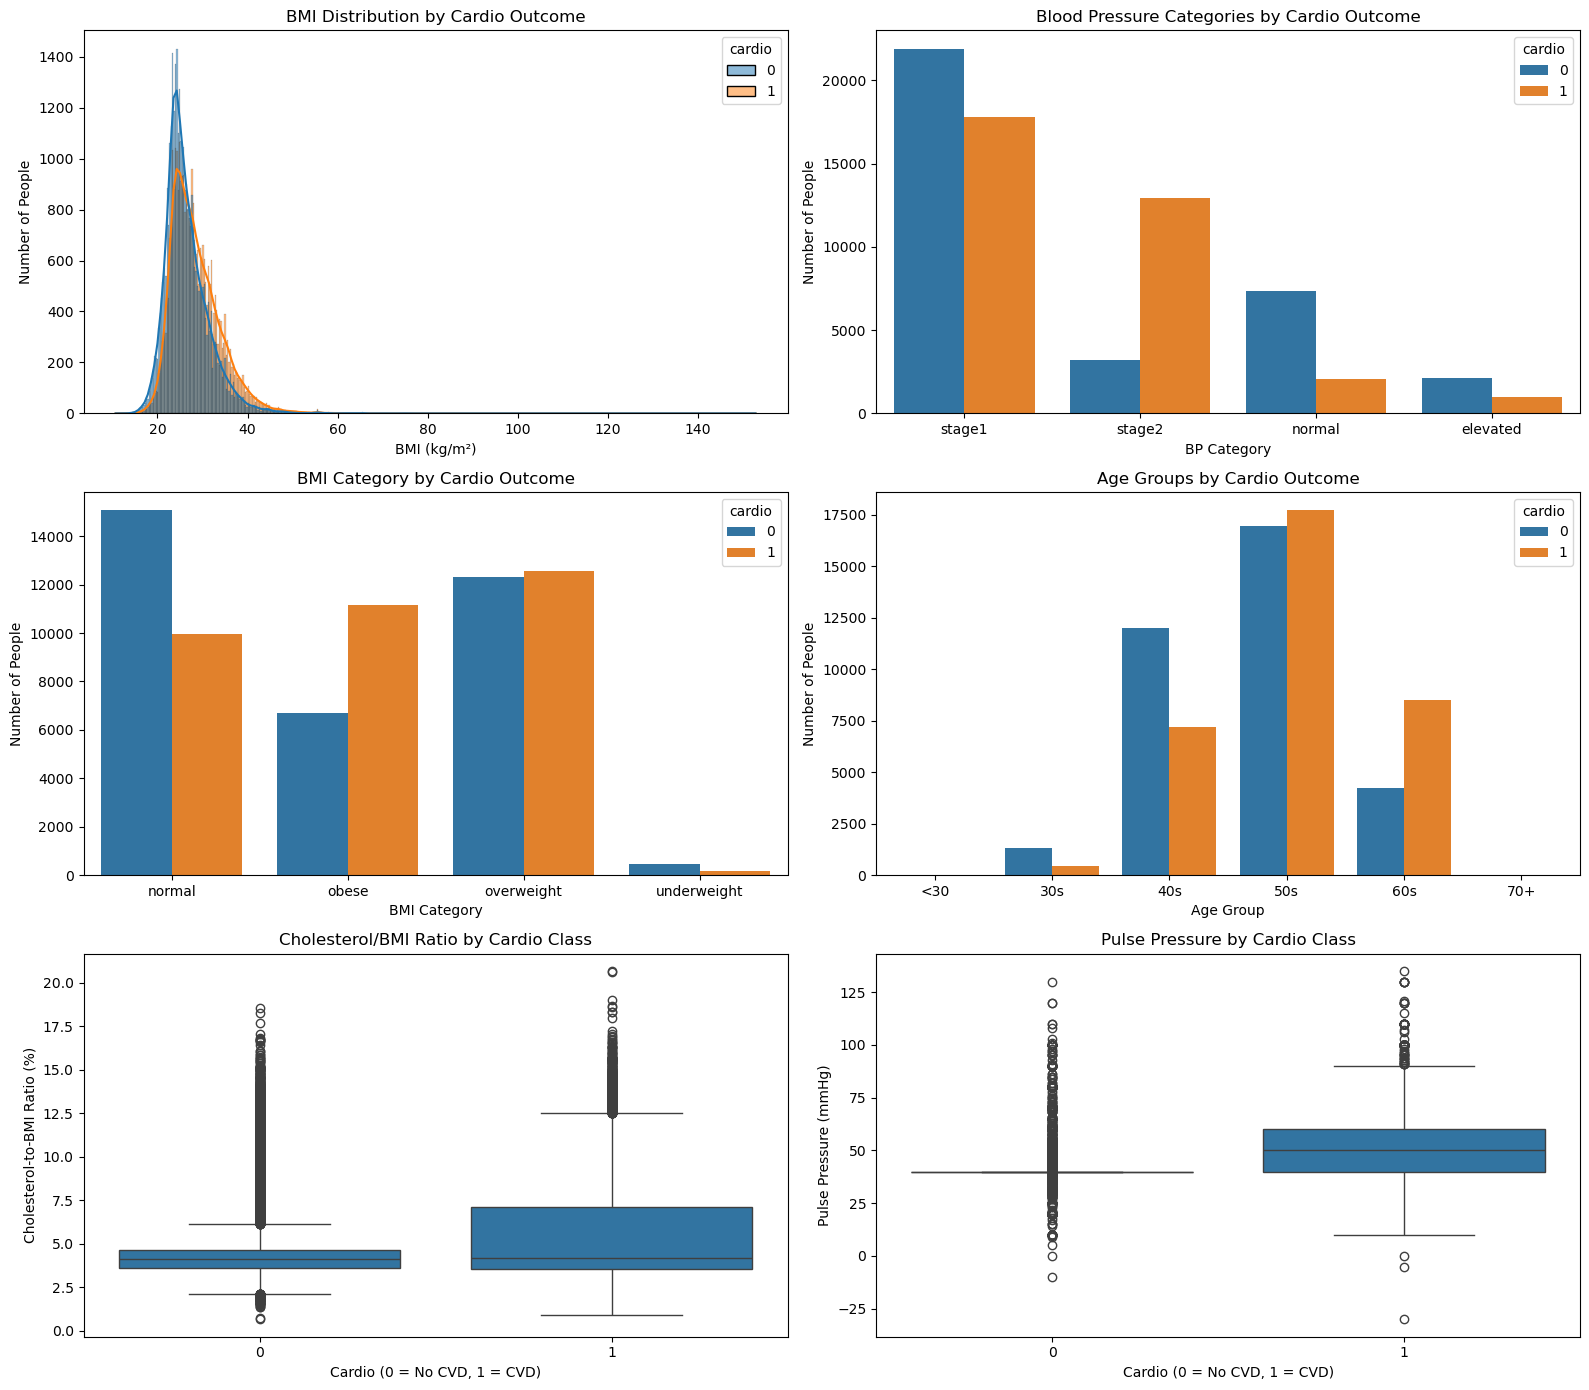

In [21]:
# Create a summary table
summary_table = pd.DataFrame({
    'Feature Name': [
        'bmi', 'age_years', 'pulse_pressure', 'is_hypertensive',
        'bp_category', 'bmi_category', 'age_group',
        'age_gluc_interaction', 'chol_bmi_ratio', 'lifestyle_score'
    ],
    'Description': [
        'Body Mass Index (kg/m²)',
        'Age in years derived from age in days',
        'Systolic minus diastolic blood pressure',
        'Binary: 1 if systolic BP ≥ 140',
        'Blood pressure category: normal to stage 2',
        'BMI classification: underweight to obese',
        'Age groups in decades',
        'Age × Glucose interaction',
        'Cholesterol-to-BMI ratio',
        'Composite score: smoke + alcohol - activity'
    ]
})

# Visualize augmented features
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# BMI distribution
sns.histplot(data=df_engineered, x='bmi', hue='cardio', kde=True, ax=axes[0, 0])
axes[0, 0].set_title("BMI Distribution by Cardio Outcome")
axes[0, 0].set_xlabel("BMI (kg/m²)")
axes[0, 0].set_ylabel("Number of People")

# Blood pressure category
sns.countplot(data=df_engineered, x='bp_category', hue='cardio', ax=axes[0, 1])
axes[0, 1].set_title("Blood Pressure Categories by Cardio Outcome")
axes[0, 1].set_xlabel("BP Category")
axes[0, 1].set_ylabel("Number of People")

# BMI category
sns.countplot(data=df_engineered, x='bmi_category', hue='cardio', ax=axes[1, 0])
axes[1, 0].set_title("BMI Category by Cardio Outcome")
axes[1, 0].set_xlabel("BMI Category")
axes[1, 0].set_ylabel("Number of People")

# Age group
sns.countplot(data=df_engineered, x='age_group', hue='cardio', ax=axes[1, 1])
axes[1, 1].set_title("Age Groups by Cardio Outcome")
axes[1, 1].set_xlabel("Age Group")
axes[1, 1].set_ylabel("Number of People")

# Cholesterol-to-BMI ratio
sns.boxplot(data=df_engineered, x='cardio', y='chol_bmi_ratio', ax=axes[2, 0])
axes[2, 0].set_title("Cholesterol/BMI Ratio by Cardio Class")
axes[2, 0].set_xlabel("Cardio (0 = No CVD, 1 = CVD)")
axes[2, 0].set_ylabel("Cholesterol-to-BMI Ratio (%)")

# Pulse pressure
sns.boxplot(data=df_engineered, x='cardio', y='pulse_pressure', ax=axes[2, 1])
axes[2, 1].set_title("Pulse Pressure by Cardio Class")
axes[2, 1].set_xlabel("Cardio (0 = No CVD, 1 = CVD)")
axes[2, 1].set_ylabel("Pulse Pressure (mmHg)")

plt.tight_layout()
plt.show()

A unique insight from this EDA is the clear dominance of the Stage 1 blood pressure category across both cardio groups, but with a sharper drop to Stage 2 in the non-CVD group compared to the CVD group. This suggests that individuals with cardiovascular disease are more likely to progress beyond Stage 1, reinforcing the role of hypertension severity in predicting disease presence.

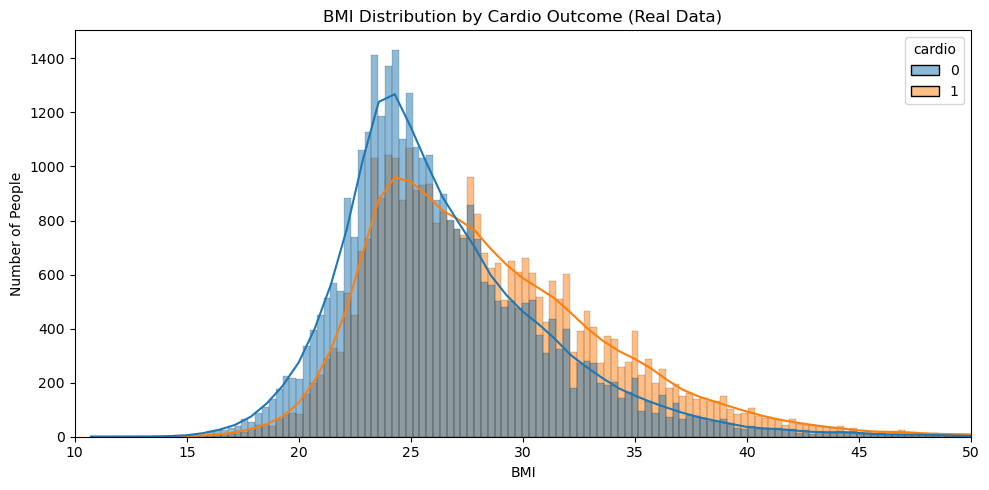

In [22]:
# BMI Distribution (zoomed in)
plt.figure(figsize=(10, 5))
sns.histplot(data=df_engineered, x='bmi', hue='cardio', kde=True)
plt.title("BMI Distribution by Cardio Outcome (Real Data)")
plt.xlabel("BMI")
plt.ylabel("Number of People")
plt.xlim(10, 50)  # Adjust as needed to zoom into relevant range
plt.tight_layout()
plt.show()

This histogram shows the BMI distribution split by cardiovascular disease outcome. Individuals with CVD (orange) tend to have higher BMI values, with the peak shifted right compared to those without CVD (blue). The right-skewed distribution indicates a heavier concentration of high-BMI individuals in the CVD group, reinforcing BMI as a modest but meaningful risk factor for heart disease.

#### Visual Insights
1. BMI Distribution
    * Cardio-positive individuals have a broader and right-shifted BMI curve, indicating higher prevalence of overweight and obesity. This pattern reinforces BMI as a relevant, though not exclusive, marker of cardiovascular risk.
2. Blood Pressure Categories
    * Both groups cluster in Stage 1, but Stage 2 hypertension appears more frequently in those with CVD. This suggests a threshold effect where blood pressure severity aligns with disease onset and progression.
3. BMI Category
    * The normal BMI group is predominantly cardio-negative, while the obese category shows a clear tilt toward cardio-positive. These categorical shifts make BMI classification a practical screening aid.
4. Age Groups
    * The 50s and 60s age ranges dominate CVD cases, especially the 60s where the cardio-positive count overtakes. This indicates not just risk with aging, but a critical inflection point for intervention in midlife.
5. Cholesterol/BMI Ratio
    * Cardio-positive individuals show a slightly higher median and variability in this ratio, suggesting metabolic inefficiency. It adds nuance by capturing combined lipid and weight influence, often missed when analyzed separately.
6. Pulse Pressure
    * Elevated pulse pressure and greater variability in cardio-positive cases highlight arterial stiffness and vascular strain, reinforcing its value as a sensitive physiological indicator for early risk detection.

In [23]:
# Show table
display(summary_table)
plt.show()

,Feature Name,Description
0,bmi,Body Mass Index (kg/m²)
1,age_years,Age in years derived from age in days
2,pulse_pressure,Systolic minus diastolic blood pressure
3,is_hypertensive,Binary: 1 if systolic BP ≥ 140
4,bp_category,Blood pressure category: normal to stage 2
5,bmi_category,BMI classification: underweight to obese
6,age_group,Age groups in decades
7,age_gluc_interaction,Age × Glucose interaction
8,chol_bmi_ratio,Cholesterol-to-BMI ratio
9,lifestyle_score,Composite score: smoke + alcohol - activity


#### Augmented Features:
* <b>bp_category</b>
Categorizes blood pressure using clinical standards (normal, elevated, stage1, stage2).<br>
→ Derived from systolic_bp and diastolic_bp.
* <b>bmi_category</b>
Converts BMI into labeled weight classes: underweight, normal, overweight, obese.<br>
→ Derived from bmi.
* <b>age_group</b>
Bins continuous age into readable decade ranges: <30, 30s, 40s, 50s, 60s, 70+.<br>
→ Derived from age_years.
* <b>age_gluc_interaction</b>
A compound feature multiplying age and glucose to capture elevated metabolic risk across age.<br>
→ Derived from age_years and gluc.
* <b>chol_bmi_ratio</b>
Cholesterol divided by BMI, scaled as a percentage to assess metabolic load relative to body mass..<br>
→ Derived from cholesterol and bmi.
* <b>lifestyle_score</b>
Composite behavior score: smoke + alco − active, where higher values may indicate unhealthier lifestyle choices.<br>
→ Derived from smoke, alco, and active.

In [24]:
# Save new features to CSM
df_engineered.to_csv("cardio_engineered.csv", index=False)

In [65]:
# Upload to your S3 bucket
!aws s3 cp cardio_engineered.csv s3://sagemaker-us-east-1-531690656306/cardio_data/

upload: ./cardio_engineered.csv to s3://sagemaker-us-east-1-531690656306/cardio_data/cardio_engineered.csv


### Data Split 
    * 40% Train
    * 10% Test
    * 10% Validation
    * 40% Production
Prior to Preprocessing to prevent data leakage

In [83]:
# Load the engineered dataset from S3
df = pd.read_csv("s3://sagemaker-us-east-1-531690656306/cardio_data/cardio_engineered.csv")

# Separate target from features
y = df['cardio']
X = df.drop(columns=['cardio'])

In [84]:
# Perform splits: 40% train, 10% val, 10% test, 40% prod
X_model, X_prod, y_model, y_prod = train_test_split(X, y, test_size=0.40, stratify=y, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X_model, y_model, test_size=0.3333, stratify=y_model, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Confirm shapes
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}, Prod: {X_prod.shape}")

Train: (27355, 23), Val: (6838, 23), Test: (6838, 23), Prod: (27354, 23)


### Preprocessing

In [85]:
# Identify feature types
categorical_cols = ['gender', 'bp_category', 'bmi_category', 'age_group', 'cholesterol_label']
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [90]:
# Fit on training set, transform all
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)
X_prod_processed = preprocessor.transform(X_prod)

# Define column names for preprocessed features
final_feature_names = numeric_cols + categorical_cols

# Fix training set
df_train_final = pd.DataFrame(X_train_processed, columns=final_feature_names)
df_train_final['cardio'] = y_train.reset_index(drop=True)

df_val_final = pd.DataFrame(X_val_processed, columns=feature_names)
df_val_final['cardio'] = y_val.reset_index(drop=True)

df_test_final = pd.DataFrame(X_test_processed, columns=feature_names)
df_test_final['cardio'] = y_test.reset_index(drop=True)

df_prod_final = pd.DataFrame(X_prod_processed, columns=feature_names)
df_prod_final['cardio'] = y_prod.reset_index(drop=True)

In [91]:
### Save to S3

# Define S3 paths
bucket_uri = "s3://sagemaker-us-east-1-531690656306/cardio_data/"

df_train_final.to_csv(f"{bucket_uri}cardio_train_split40%_v2.csv", index=False)
df_val_final.to_csv(f"{bucket_uri}cardio_val_split10%_v2.csv", index=False)
df_test_final.to_csv(f"{bucket_uri}cardio_test_split10%_v2.csv", index=False)
df_prod_final.to_csv(f"{bucket_uri}cardio_prod_split40%_v2.csv", index=False)

print("All preprocessed datasets successfully saved to S3.")

All preprocessed datasets successfully saved to S3.


#### Visualize all CSV files saved in S3

In [98]:
# S3 client setup
s3 = boto3.client('s3')
bucket_name = 'sagemaker-us-east-1-531690656306'
prefix = 'cardio_data/'

# List all CSV files in the cardio_data folder
objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)
file_keys = [obj['Key'] for obj in objects.get('Contents', []) if obj['Key'].endswith('.csv')]

# Check structure of each CSV and ensure train split contains all features
csv_shapes = {}
csv_columns = {}

for key in file_keys:
    try:
        response = s3.get_object(Bucket=bucket_name, Key=key)
        df = pd.read_csv(response['Body'])
        csv_shapes[key] = df.shape
        csv_columns[key] = df.columns.tolist()
    except Exception as e:
        csv_shapes[key] = f"Error: {e}"
        csv_columns[key] = []

# Display results
pd.DataFrame({
    "File": list(csv_shapes.keys()),
    "Shape": list(csv_shapes.values()),
    "Columns": list(csv_columns.values())
})

,File,Shape,Columns
0,cardio_data/cardio_cleaned.csv,"(68385, 12)","[age, gender, height_ft, weight_lbs, systolic_..."
1,cardio_data/cardio_engineered.csv,"(68385, 24)","[age, gender, height_ft, weight_lbs, systolic_..."
2,cardio_data/cardio_prod_split40%_v2.csv,"(27354, 24)","[age, height_ft, weight_lbs, systolic_bp, dias..."
3,cardio_data/cardio_test_split10%_v2.csv,"(6838, 24)","[age, height_ft, weight_lbs, systolic_bp, dias..."
4,cardio_data/cardio_train.csv,"(70000, 1)",[id;age;gender;height;weight;ap_hi;ap_lo;chole...
5,cardio_data/cardio_train_split40%_v2.csv,"(27355, 24)","[age, height_ft, weight_lbs, systolic_bp, dias..."
6,cardio_data/cardio_val_split10%_v2.csv,"(6838, 24)","[age, height_ft, weight_lbs, systolic_bp, dias..."


<div align="center">
  <h3>Cardiovascular Dataset Summary</h3>
</div>

| File Path                          | Label                   | Shape          | Main Use Case                | Human-readable? | Notes                                                                 |
|-----------------------------------|--------------------------|----------------|-------------------------------|------------------|------------------------------------------------------------------------|
| `cardio_train.csv`                | Original Dataset         | (70,000, 13)   | Starting point for pipeline   | Yes              | Raw source file; semicolon-separated; requires cleaning and parsing    |
| `cardio_cleaned.csv`              | Cleaned Dataset          | (68,385, 12)   | EDA + Feature Engineering     | Yes              | Cleaned and formatted; interpretable values                            |
| `cardio_engineered.csv`           | Engineered Dataset       | (68,385, 24)   | Feature engineering & augmentation | Yes          | Includes BMI, pulse pressure, age groupings, and interaction features  |
| `cardio_train_split40%_v2.csv`    | Training Split (40%)     | (27,355, 24)   | Model training                | No               | Preprocessed, includes scaled numeric and encoded categorical features |
| `cardio_val_split10%_v2.csv`      | Validation Split (10%)   | (6,838, 24)    | Model tuning                  | No               | Used for validation and tuning during model development                |
| `cardio_test_split10%_v2.csv`     | Test Split (10%)         | (6,838, 24)    | Final model evaluation        | No               | Used to assess model generalization performance                        |
| `cardio_prod_split40%_v2.csv`     | Production Reserve (40%) | (27,354, 24)   | Future inference or deployment| No               | Reserved for future predictions or real-world application simulation   |

In [101]:
!aws s3 cp cardio_data_split_v3.ipynb s3://sagemaker-us-east-1-531690656306/cardio_project/

upload: ./cardio_data_split_v3.ipynb to s3://sagemaker-us-east-1-531690656306/cardio_project/cardio_data_split_v3.ipynb


### Baseline Model
#### Logistic Regression

### Train Initial Model
#### Random Forest or XG Boost

### Shap Explanability Analysis

### Model Evaluation

### Model Selection and Final Training

### Model Deployment

### Model Monitoriing